In [1]:
#%reset
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import os 
from matplotlib.patches import Polygon
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
#from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'REGION', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75',
       'Trend_N_greater_75'],
      dtype='object')


In [5]:


################################ Get hyperparameters and best features for each model  ###########################
#### Loop set up 
threshold_seq = np.linspace(0,1,101)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest
model_types = ["Logistic_regression",  "Random_forest", "Neural_network"]
i = 0

# logistic regression - random initial parameters
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')
# random forest - random initial parameters
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)
# neural network - random parameters
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )
unfitted_models = [model_lr, model_rf, model_nn]

### Hyperparameter tuning
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
# logistic regression 
best_hyperparameters_by_year = {}

space_lr = dict()
space_lr['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space_lr['penalty'] = ['l1', 'l2']
space_lr['C'] = np.arange(0, 100, .01)
best_hyperparameters_by_year_lr = {}
# random forest 
space_rf = dict()
space_rf['n_estimators'] = np.arange(100, 201, 1)
space_rf['max_depth'] = np.arange(1, 200, 1)
space_rf['min_samples_split'] = np.arange(1, 25, 1)
space_rf['min_samples_leaf'] = np.arange(1, 25, 1)
best_hyperparameters_by_year[model_type]{}

# neural network 
space_nn = dict()
space_nn['solver'] = ['lbfgs', 'sgd', 'adam']
space_nn['activation'] = ['tanh', 'relu']
space_nn['alpha'] = np.logspace(-1, 1, 10)
space_nn['learning_rate'] = ['constant','adaptive']
space_nn['hidden_layer_sizes'] = [(4,), (6,), (8,), (10,), (12,), (13,), (14,)]
best_hyperparameters_by_year_nn = {}

space = [space_lr, space_rf, space_nn]
best_hyperparameters_by_year = [best_hyperparameters_by_year_lr, best_hyperparameters_by_year[model_type],best_hyperparameters_by_year_nn]

### Feature Engineering
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']
best_features_by_year[model_type]_lr = {}
best_features_by_year_rf = {}
best_features_by_year_nn = {}
best_features_by_year = [best_features_by_year_lr, best_features_by_year_rf, best_features_by_year_nn]

imporances_all_models = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))
indices_for_importance = [6,12,0] ## need to be in correct order 
imporances_all_models_sd = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))


oversample = RandomOverSampler(sampling_strategy='minority', random_state=10)

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)

def get_feature_effects(all_features, important_features, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features

def get_feature_effects_sd(feature_names, important_features,model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=42
    )

    return PI.importances_std

def get_best_hyperparameters(model, cv, space, X_train, y_train, sample_weights):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=20, n_jobs=-1, cv=cv, random_state=1
    )
    result = search.fit(X_train, y_train, sample_weight = sample_weights)
    return result.best_params_

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):
    feature_names_with_weight = feature_names.copy()
    feature_names_with_weight.extend(['weight'])
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[feature_names_with_weight]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names_with_weight]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)

    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    weights_train = X_train["weight"]
    X_train  = X_train.drop("weight", axis = 1)
    X_test = X_test.drop("weight", axis = 1)

    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train)

In [112]:
# Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)
    best_hyperparameters1 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters1['solver'], C = best_hyperparameters1['C'], penalty = best_hyperparameters1['penalty'])
    
    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_fit = model_lr.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_lr, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 


    ## fit model w/hyperparameters 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=5000, solver = best_hyperparameters2['solver'], C = best_hyperparameters2['C'], penalty = best_hyperparameters2['penalty'])

    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    print(ROC)
    i += 1

2005


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.7301280825377211
2006


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.688908716090679
2007


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6859769375400482
2008


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.706340000521553
2009


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6455044050644695
2010


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

Hyperparameters1


/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/rem76/miniconda3/envs/GISP_init/lib/python3.10

0.6526505174435401


In [114]:
print("RF:", ROC_by_year)
print("RF:",best_hyperparameters_by_year)
print("RF:",best_features_by_year)

RF: [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {}, {}]
RF: [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {}, {}]
RF: [{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'Southeast', 'Northeast'], 2008: ['West', 'MSW', 'PREV_CLINIC', 'Southeast', 'Northeast', 'Oth/Unk/Missing'], 2009: ['West', 'PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2010: ['MSM', 'PREV_C

In [ ]:
ROC_by_year = [{2005: 0.7301280825377211, 2006: 0.7118669195200309, 2007: 0.6859769375400482, 2008: 0.6768972801001382, 2009: 0.6455044050644695, 2010: 0.6601163469109158}, {}, {}]
best_hyperparameters_by_year =[{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}}, {2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}}, {}]
best_features_by_year =[{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest', 'Southeast', 'MSW'], 2007: ['MSW', 'Oth/Unk/Missing', 'West'], 2008: ['West', 'MSW', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Northeast'], 2009: ['West', 'PREV_CLINIC', 'MSW', 'MSM', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75'], 2010: ['MSM', 'PREV_CLINIC', 'DELTA_REGION', 'West', 'MSW', 'PREV_REGION', 'MSMW', 'Southeast', 'Southwest', 'Count_Exceeds_75']}, {}, {}]

In [115]:
imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv')

In [116]:
## Just RF
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

space = dict()
space['n_estimators'] = np.arange(1, 201, 1)
space['max_depth'] = np.arange(1, 200, 1)
space['min_samples_split'] = np.arange(1, 100, 1)
space['min_samples_leaf'] = np.arange(1, 100, 1)
test_years = [2005, 2006, 2007, 2008, 2009, 2010]  #np.array(range(2005, 2011))

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type)

    ## before fitting the model, do hyperparameter tuning 
    best_hyperparameters1 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters1['n_estimators'], min_samples_split = best_hyperparameters1['min_samples_split'], min_samples_leaf=best_hyperparameters1['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters1['max_depth'], random_state = 10)
    
     
    ## fit model w/hyperparameters 
    model_fit = model_rf.fit(X_train, y_train, sample_weight = weights_train)

    ## now also need to do feature engineering
    important_features = get_best_features(feature_names, model_fit, X_train, y_train)
    best_features_by_year[model_type].__setitem__(year, important_features) 
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects(feature_names, important_features, model_fit, X_train, y_train) #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type)
    
    best_hyperparameters2 = get_best_hyperparameters(model_rf, cv, space, X_train, y_train, weights_train)
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) 



    ## fit model w/hyperparameters 
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters2['n_estimators'], min_samples_split = best_hyperparameters2['min_samples_split'], min_samples_leaf=best_hyperparameters2['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters2['max_depth'], random_state = 10)

    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = weights_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

2005
Oversample
Oversample
2006
Oversample
Oversample
2007
Oversample
Oversample
2008
Oversample
Oversample
2009
Oversample
Oversample
2010
Oversample
Oversample


In [120]:
print("RF:",ROC_by_year)
print("RF:",best_hyperparameters_by_year)
print("RF:",best_features_by_year)
imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv', index = False)

RF: [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {2005: 0.7422861470301229, 2006: 0.716008241481748, 2007: 0.6904656174878919, 2008: 0.6891381333611495, 2009: 0.6675168178659392, 2010: 0.6670052565692955}, {}]
RF: [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators

In [8]:
ROC_by_year = [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {2005: 0.7422861470301229, 2006: 0.716008241481748, 2007: 0.6904656174878919, 2008: 0.6891381333611495, 2009: 0.6675168178659392, 2010: 0.6670052565692955}, {}]
best_hyperparameters_by_year =  [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}, {}]
best_features_by_year = [{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'Southeast', 'Northeast'], 2008: ['West', 'MSW', 'PREV_CLINIC', 'Southeast', 'Northeast', 'Oth/Unk/Missing'], 2009: ['West', 'PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2010: ['MSM', 'PREV_CLINIC', 'DELTA_REGION', 'MSW', 'PREV_REGION', 'West', 'Southeast', 'Southwest', 'Northeast', 'MSMW', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Midwest', 'Trend_N_greater_75', 'Southeast', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Southeast', 'Southwest', 'Oth/Unk/Missing', 'Midwest', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Northeast', 'Trend_N_greater_75', 'Midwest', 'Southwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Southwest', 'Midwest', 'Trend_N_greater_75', 'Northeast', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'West', 'Southwest', 'Southeast', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Trend_N_greater_75', 'Northeast'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Southeast', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75']}, {}]
imporances_all_models= pd.read_csv('imporances_all_models_with_weights_and_count_features.csv')

# tensorflow

In [14]:

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):

    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[
        feature_names
    ]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)
    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev)

def get_feature_effects(all_features, important_features, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    feature_importances = []
    for feature in all_features:
        if feature in important_features:
            feature_importances.append(PI.importances_mean[important_features.index(feature)])
        else:
            feature_importances.append(0)
    return feature_importances

def get_best_features(feature_names, model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=0
    )
    important_features = []
    for q in PI.importances_mean.argsort()[::-1]:
        if PI.importances_mean[q] - PI.importances_std[q] >0:
            important_features.append(
                feature_names[q]
            )  # works cos they are in same order as the x columns
    return important_features

def get_feature_effects_sd(feature_names, important_features,model_fit, X_train, y_train):
    PI = permutation_importance(
        model_fit, X_train, y_train, n_repeats=10, random_state=42
    )

    return PI.importances_std

def get_best_hyperparameters(model, cv, space, X_train, y_train, sample_weights):
    search = RandomizedSearchCV(
        model, space, scoring="roc_auc", n_iter=20, n_jobs=-1, cv=cv, random_state=1
    )
    result = search.fit(X_train, y_train, sample_weight = sample_weights)
    return result.best_params_

### ROC by year 
ROC_by_year_rf = {}
ROC_by_year_lr = {}
ROC_by_year_nn = {}

ROC_by_year = [ROC_by_year_lr, ROC_by_year_rf, ROC_by_year_nn]


def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):
    feature_names_with_weight = feature_names.copy()
    feature_names_with_weight.extend(['weight'])
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[feature_names_with_weight]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names_with_weight]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)

    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    weights_train = X_train["weight"]
    X_train  = X_train.drop("weight", axis = 1)
    X_test = X_test.drop("weight", axis = 1)

    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train)

# SciKt Learn MLP classifier doesn't allow for sample weights, so need to use keras

In [17]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

In [15]:
def get_best_features_tensor_flow(feature_names, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    important_features = []

    for feature in feature_names:
        X_permuted = X_train.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        permuted_score = np.mean([calculate_score(X_permuted, y_train) for _ in range(n_repeats)])
        importance = baseline_score - permuted_score

        if importance > 0:  # Only consider features that improve the score
            important_features.append(feature)

    return important_features

def get_feature_effects_sd_tensor_flow(feature_names, important_features, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    feature_effects_sd = {}

    for feature in important_features:
        X_permuted = X_train.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])

        permuted_scores = [calculate_score(X_permuted, y_train) for _ in range(n_repeats)]
        effect_sd = np.std(permuted_scores)

        feature_effects_sd[feature] = effect_sd

    return feature_effects_sd

def get_feature_effects_tensor_flow(all_features, important_features, model_fit, X_train, y_train, n_repeats=10):
    def calculate_score(X, y):
        y_pred = model_fit.predict(X)
        return roc_auc_score(y, y_pred)  # Replace 'roc_auc_score' with your desired metric

    baseline_score = calculate_score(X_train, y_train)
    feature_importances = []

    for feature in all_features:
        if feature in important_features:
            X_permuted = X_train.copy()
            X_permuted[feature] = np.random.permutation(X_permuted[feature])

            permuted_scores = [calculate_score(X_permuted, y_train) for _ in range(n_repeats)]
            effect = baseline_score - np.mean(permuted_scores)
        else:
            effect = 0

        feature_importances.append(effect)

    return feature_importances

In [ ]:
import keras
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier
from keras.layers import Dense, Dropout
from keras import Sequential
from tensorflow.keras.metrics import AUC
from tensorflow import random    

def get_best_hyperparameters_tensorflow(estimator, param_space, cv, X_train, y_train, sample_weights):
    grid = RandomizedSearchCV(estimator, param_space, scoring="roc_auc", n_iter=10, n_jobs=-1, cv=cv, random_state=1);
    grid_result = grid.fit(X_train, y_train, kc__sample_weight=sample_weights);
    params = grid_result.best_params_
    return params 
random.set_seed(10)
np.random.seed(10)

def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=1, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

# define the grid search parameters
param_grid = {
    'kc__dense_nparams': [2,4, 6, 8, 10, 12, 14, 16],
    'kc__batch_size': [5, 10, 15, 20],
    'kc__optimizer': [ 'Adamax'],
    'kc__dropout': [0.075, 0.03, 0.05, 0.04, 0.025, 0]
}

i = 0
def get_best_hyperparameters_tensorflow(estimator, param_space, cv, X_train, y_train, sample_weights):
    grid = RandomizedSearchCV(estimator, param_space, scoring="roc_auc", n_iter=10, n_jobs=-1, cv=cv, random_state=1);
    grid_result = grid.fit(X_train, y_train, kc__sample_weight=sample_weights);
    params = grid_result.best_params_
    return params 

np.random.seed(10)

def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=1, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

# define the grid search parameters
param_grid = {
    'kc__dense_nparams': [2,4, 6, 8, 10, 12, 14, 16],
    'kc__batch_size': [5, 10, 15, 20],
    'kc__optimizer': [ 'Adamax'],
    'kc__dropout': [0.075, 0.03, 0.05, 0.04, 0.025, 0]
}
test_years = [2010]
i = 5
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count');
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count');

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'));

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum();

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts;
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left');

 
    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = feature_names, years_train = years_train, model_type = model_type);
    best_hyperparameters1 = get_best_hyperparameters_tensorflow(estimator = estimator, param_space = param_grid, cv = cv, X_train = X_train, y_train = y_train, sample_weights = weights_train);
    model_nn = create_model(optimizer=best_hyperparameters1['kc__optimizer'], init='uniform', dropout=best_hyperparameters1['kc__dropout'], dense_nparams=best_hyperparameters1['kc__dense_nparams']);

    print("Hyperparameters1")
    ## fit model w/hyperparameters 
    model_nn.fit(X_train, y_train, epochs=10, batch_size=best_hyperparameters1['kc__batch_size'], sample_weight=weights_train);
    #model_fit = model_nn.copy()
    ## now also need to do feature engineering
    important_features = get_best_features_tensor_flow(feature_names, model_nn, X_train, y_train, n_repeats=10);
    best_features_by_year[model_type].__setitem__(year, important_features);
    imporances_all_models[i + indices_for_importance[model_type]] = get_feature_effects_tensor_flow(feature_names, important_features, model_nn, X_train, y_train); #want it to be the correct block for each model
    imporances_all_models_sd[i + indices_for_importance[model_type]] = get_feature_effects_sd_tensor_flow(feature_names, important_features, model_nn, X_train, y_train); #want it to be the correct block for each model

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = important_features, years_train = years_train, model_type = model_type);
    def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
        model = Sequential()
        model.add(Dense(dense_nparams, activation='relu', input_shape=(len(important_features),), kernel_initializer=init))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
        return model
    kears_estimator = KerasClassifier(model=create_model, verbose=1, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
    estimator = Pipeline([
       ('ss', StandardScaler()),
        ("kc", kears_estimator)
    ])
    best_hyperparameters2 = get_best_hyperparameters_tensorflow(estimator = estimator, param_space = param_grid, cv = cv, X_train = X_train, y_train = y_train, sample_weights = weights_train);
    best_hyperparameters_by_year[model_type].__setitem__(year, best_hyperparameters2) ;
    model_nn = create_model(optimizer=best_hyperparameters2['kc__optimizer'], init='uniform', dropout=best_hyperparameters2['kc__dropout'], dense_nparams=best_hyperparameters2['kc__dense_nparams']);

    print("Hyperparameters2")
    ## fit model w/hyperparameters 
    model_nn.fit(X_train, y_train, epochs=100, batch_size=best_hyperparameters2['kc__batch_size'], sample_weight=weights_train);

    # Make predictions on test data
    y_predict_proba = model_nn.predict(X_test);

    # Calculate AUROC on test data
    auc_metric = keras.metrics.AUC(num_thresholds=100);
    auc_metric.update_state(y_test, y_predict_proba);
    auroc = auc_metric.result().numpy();
 
    ROC_by_year[model_type].__setitem__(year, auroc);
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1);
    print(auroc)
    i += 1;

In [47]:
print("RF:",ROC_by_year)
print("RF:",best_hyperparameters_by_year)
print("RF:",best_features_by_year)
#imporances_all_models.to_csv('imporances_all_models_with_weights_and_count_features.csv', index = False)
#imporances_all_models= pd.read_csv('imporances_all_models_with_weights_and_count_features.csv')

ROC_by_year = [{2005: 0.7301280825377211, 2006: 0.688908716090679, 2007: 0.6859769375400482, 2008: 0.706340000521553, 2009: 0.6455044050644695, 2010: 0.6526505174435401}, {2005: 0.7422861470301229, 2006: 0.716008241481748, 2007: 0.6904656174878919, 2008: 0.6891381333611495, 2009: 0.6675168178659392, 2010: 0.6670052565692955},  {2005: 0.80996376, 2006: 0.8276598, 2007: 0.7528771, 2008: 0.765494, 2009: 0.7480822, 2010: 0.7450418}]
best_hyperparameters_by_year = [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}, {2005: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2006: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2007: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2008: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}, 2009: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2010: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}}]
best_features_by_year = [{2005: ['West', 'Southwest', 'Northeast', 'MSW', 'MSM', 'Trend_N_greater_75'], 2006: ['West', 'Southwest'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'Southeast', 'Northeast'], 2008: ['West', 'MSW', 'PREV_CLINIC', 'Southeast', 'Northeast', 'Oth/Unk/Missing'], 2009: ['West', 'PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'Southeast', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Count_Exceeds_75'], 2010: ['MSM', 'PREV_CLINIC', 'DELTA_REGION', 'MSW', 'PREV_REGION', 'West', 'Southeast', 'Southwest', 'Northeast', 'MSMW', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Midwest', 'Trend_N_greater_75', 'Southeast', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Southeast', 'Southwest', 'Oth/Unk/Missing', 'Midwest', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Northeast', 'Trend_N_greater_75', 'Midwest', 'Southwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Southwest', 'Midwest', 'Trend_N_greater_75', 'Northeast', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'West', 'Southwest', 'Southeast', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Trend_N_greater_75', 'Northeast'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Southeast', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Oth/Unk/Missing', 'Trend_N_greater_75']}, {2005: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2006: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2007: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2008: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2009: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2010: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'Count_Exceeds_75', 'Trend_N_greater_75']}]

RF: [{}, {}, {2005: 0.80996376, 2006: 0.8276598, 2007: 0.7528771, 2008: 0.765494, 2009: 0.7480822, 2010: 0.7450418}]
RF: [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 55.0}, 2007: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 20.28}, 2008: {'solver': 'liblinear', 'penalty': 'l1', 'C': 35.730000000000004}, 2009: {'solver': 'liblinear', 'penalty': 'l1', 'C': 81.83}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 54.85}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samp

# auROC, features, and hyperparameters with weights caclulated by training set and extra features 
LR and RF 

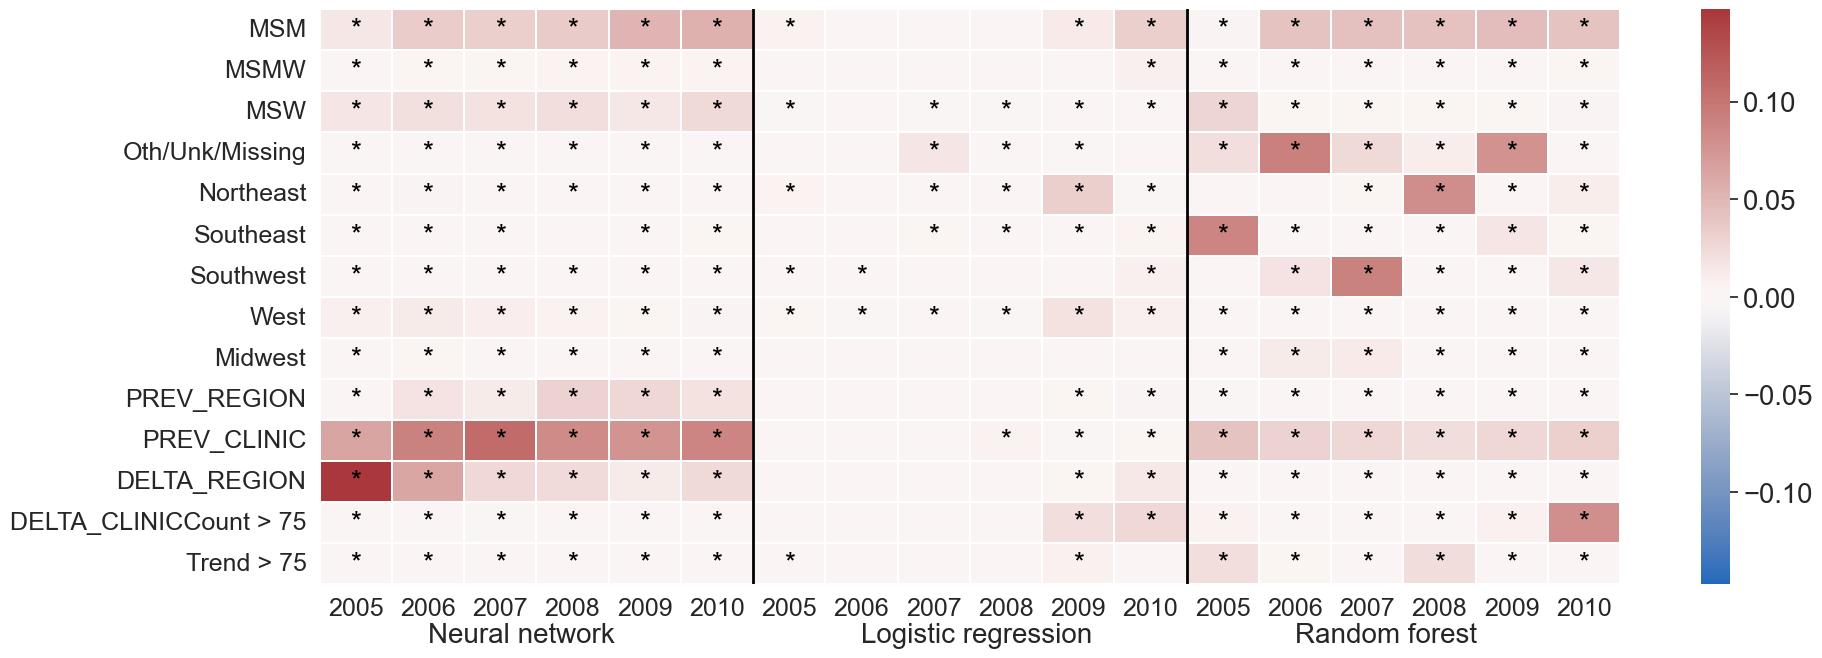

In [92]:
### Graph 2 of important features 
## Figure 1: Graph of important features

fig, ax = plt.subplots(figsize=(20,7))
sb.set(font_scale=1.8)
x_axis_labels = [2005,2006,2007,2008,2009,2010]*3
y_axis_labels =['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R']
y_axis_labels = ['MSM','MSMW', 'MSW', 'Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Regional CIP-R', 'Local CIP-R','Regional change in CIP-R', 'Local change in CIP-R', 'Count > 75', 'Trend > 75']

y_axis_labels = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC' 'Count > 75', 'Trend > 75']
ax.tick_params(axis='both', which='major', labelsize=18)

sb.heatmap(imporances_all_models,fmt="",cmap='vlag',linewidths=0.30,ax=ax, xticklabels = x_axis_labels, yticklabels = y_axis_labels, vmin =-abs(imporances_all_models.max()).max(), vmax = abs(imporances_all_models.max()).max())
ax.text((ax.get_xlim()[1])/18 * 1.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Neural network", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 7.5, (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Logistic regression", fontsize=20)
ax.text((ax.get_xlim()[1])/18 * 13.5 , (ax.get_ylim()[0]) + (ax.get_ylim()[0])*0.10, "Random forest", fontsize=20)
ax.axvline((ax.get_xlim()[1])/18 * 6, color = "black", linewidth = 2)
ax.axvline((ax.get_xlim()[1])/18 * 12, color = "black", linewidth = 2)
plt.tight_layout()
included_features = pd.DataFrame(0, index = feature_names, columns=np.arange(len(test_years)*3))

model_types = [0, 1, 2]
test_years = [2005, 2006, 2007, 2008, 2009, 2010]

for model in model_types:
    if model == 0:
             j = 6
    elif model == 1:
             j = 12
    elif model == 2:
             j =0
    for year in test_years:
        matched_indices = np.where(np.isin(feature_names, list(set(best_features_by_year[model][year]))))[0]

        for i in matched_indices:
                ax.text(j + 0.5, i + 0.5, '*', color='black', size=20, ha='center', va='center')
        j +=1
plt.show()

# Functions for bootstrapping

In [10]:
def calculate_percentiles(iterations, ROC_actual, test_data, model_type,y_test):
        bootstrapped_stats = []
        for j in range(iterations):
            model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            ## don't need to read in weights as the model has already been trained
            X_train_bootstrap = pd.read_csv(X_data_name)
            model_fit = pickle.load(open(model_name, 'rb'))
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            y_bootstrap_predict = model_fit.predict(X_test_for_bootstrap)
            ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

            difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

            bootstrapped_stats.append({'Difference': difference})


        bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization
        alpha = 0.05
        #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
        #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
        upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
        #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
        #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance

        return lower_quartile, upper_quartile

### now try bootstrapping w/o feature selection
iterations = 100
## DO NOT SAMPLE THE TARGET DATA
def bootstrap_auROC_no_dev(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
      #1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    for i in range(iterations):
        #2. (A) Sample all individuals from training data w/replacement

          sample_train = train_data.sample(frac = 1, replace=True) ##(a) sample n individuals with replacement
          
          X_sample_train = sample_train[feature_names_with_weight]
          y_sample_train = 1 - sample_train['Susceptible']

          if model_type in [1,2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train,y_sample_train)
          weights_train = X_sample_train["weight"]
          X_sample_train  = X_sample_train.drop("weight", axis = 1)
        #  (B) Predictive model w/o feature selection 
          X_test_bootstrap = test_data[important_features]
          model_fit = model.fit(X_sample_train, y_sample_train, sample_weight = weights_train)

          model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".sav" 
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          y_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          weights_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_weights_" + str(model_type) + "_" + str(year) + "_" + str(i) + ".csv" 
          
          weights_train.to_csv(weights_data_name)
          X_sample_train.to_csv(X_data_name)
          y_sample_train.to_csv(y_data_name)
          pickle.dump(model_fit, open(model_name, 'wb'))
        #  (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
          y_bootstrap_predict = model_fit.predict(X_test_bootstrap)
          ROC_AUC_bootstrap_test_performance = metrics.roc_auc_score(y_test, y_bootstrap_predict) 
        ### (D) Calculate estimate fo variance  by getting (B) - (D) 

          difference = ROC_AUC_bootstrap_test_performance - ROC_actual ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/

          bootstrapped_stats.append(
          {

              'Difference': difference#,
          }
        )


    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)
    ## Step 3: Get average optimization

    #lower_quartile = np.percentile(bootstrapped_stats["Difference"], 2.5)
    #upper_quartile = np.percentile(bootstrapped_stats["Difference"], 97.5)
 ## Step 4: Get optimization-corrected performance
    alpha = 0.05 
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile


def bootstrap_auROC_no_dev_tensorflow(iterations, model, train_data, test_data, y_test, ROC_actual, important_features):
    # 1. Find apparent model performance
    bootstrapped_stats = []
    feature_names_with_weight = important_features.copy()
    feature_names_with_weight.extend(['weight'])
    
    for i in range(iterations):
        # 2. (A) Sample all individuals from training data w/replacement
        sample_train = train_data.sample(frac = 1, replace=True)

        X_sample_train = sample_train[feature_names_with_weight]
        y_sample_train = 1 - sample_train['Susceptible']

        if model_type in [1, 2]:
            X_sample_train, y_sample_train = oversample.fit_resample(X_sample_train, y_sample_train)

        weights_train = X_sample_train["weight"]
        X_sample_train = X_sample_train.drop("weight", axis=1)

        # (B) Predictive model w/o feature selection
        X_test_bootstrap = test_data[important_features]

        model.fit(X_sample_train, y_sample_train, sample_weight=weights_train, epochs=100, batch_size=32, verbose=0)

        model_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_{model_type}_{year}_{i}.sav"
        X_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_{model_type}_{year}_{i}.csv"
        y_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_y_no_dev_{model_type}_{year}_{i}.csv"
        weights_data_name = f"/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_weights_{model_type}_{year}_{i}.csv"

        weights_train.to_csv(weights_data_name)
        X_sample_train.to_csv(X_data_name)
        y_sample_train.to_csv(y_data_name)
        pickle.dump(model_nn, open(model_name, 'wb'))

        # (C) Performance of predictive model on original sample (i.e. original training population, X_test, with new selected features)
        y_bootstrap_predict = model.predict_classes(X_test_bootstrap)
        ROC_AUC_bootstrap_test_performance = roc_auc_score(y_test, y_bootstrap_predict)

        # (D) Calculate estimate of variance by getting (B) - (C)
        difference = ROC_AUC_bootstrap_test_performance - ROC_actual

        bootstrapped_stats.append({
            'Difference': difference
        })

    bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

    # Step 3: Get average optimization
    lower_quartile, upper_quartile = np.percentile(bootstrapped_stats["Difference"], [2.5, 97.5])

    # Step 4: Get optimization-corrected performance
    alpha = 0.05
    upper_quartile, lower_quartile = ROC_actual - np.percentile(bootstrapped_stats["Difference"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])

    return lower_quartile, upper_quartile

In [7]:
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]


In [231]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)

In [127]:
# RF bootstrapping 
model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

i = 0
for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    model_rf = RandomForestClassifier(n_estimators = best_hyperparameters_by_year[model_type][year]['n_estimators'], min_samples_split = best_hyperparameters_by_year[model_type][year]['min_samples_split'], min_samples_leaf=best_hyperparameters_by_year[model_type][year]['min_samples_leaf'], max_features = 'sqrt', max_depth = best_hyperparameters_by_year[model_type][year]['max_depth'], random_state = 10)

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
   
    model_name = "CIP_rf_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_rf.fit(X_train, y_train, sample_weight = sample_weights)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_rf_" + str(year) + ".sav" 
    pickle.dump(model_rf, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)

    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)

2005
Oversample
2006
Oversample
2007
Oversample
2008
Oversample
2009
Oversample
2010
Oversample


In [125]:
## Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

i = 0
for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
 
    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
       ## fit model w/hyperparameters 
    model_name = "CIP_lr_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_fit_train = model_lr.fit(X_train, y_train, sample_weight = sample_weights)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    pickle.dump(model_lr, open(model_name, 'wb'))
    #ROC= metrics.roc_auc_score(y_test, y_predict_test)
    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year_lr[year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev(iterations, model_lr, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    lower_quartile_by_year[model_type].__setitem__(year, lower_quartile)
    upper_quartile_by_year[model_type].__setitem__(year, upper_quartile)
    

2005
2006
2007
2008
2009
2010


In [ ]:
def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(len(feature_names),), kernel_initializer=init))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
    return model

kears_estimator = KerasClassifier(model=create_model, verbose=1, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)

estimator = Pipeline([
    ('ss', StandardScaler()),  # Use StandardScaler for numerical features
    ("kc", kears_estimator)
])

# define the grid search parameters
param_grid = {
    'kc__dense_nparams': [2,4, 6, 8, 10, 12, 14, 16],
    'kc__batch_size': [5, 10, 15, 20],
    'kc__optimizer': [ 'Adamax'],
    'kc__dropout': [0.075, 0.03, 0.05, 0.04, 0.025, 0]
}
test_years = [2008, 2009, 2010]
i = 2
for year in test_years: 
    print(year)
    model_type = 2
    years_train = np.array(range(year - 5, year));

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)];
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])];
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count');
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count');

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'));

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum();

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts;
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left');

    # get new test/train data and hyperparameter tuning round 2 

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type);
    
    def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=2500, dense_nparams=256):
        model = Sequential()
        model.add(Dense(dense_nparams, activation='relu', input_shape=(len(important_features),), kernel_initializer=init))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[AUC()])
        return model
    kears_estimator = KerasClassifier(model=create_model, verbose=1, init='zeros',dropout=0.1, dense_nparams=8, random_state = 10)
    estimator = Pipeline([
       ('ss', StandardScaler()),
        ("kc", kears_estimator)
    ])

    model_nn = create_model(optimizer=best_hyperparameters_by_year[model_type][year]['kc__optimizer'], init='uniform', dropout=best_hyperparameters_by_year[model_type][year]['kc__dropout'], dense_nparams=best_hyperparameters_by_year[model_type][year]['kc__dense_nparams']);

    model_name = "CIP_nn_" + str(year) + ".sav" 
    #model_fit_train = pickle.load(open(model_name, 'rb'))
    model_nn.fit(X_train, y_train, epochs=100, batch_size=best_hyperparameters_by_year[model_type][year]['kc__batch_size'], sample_weight=weights_train);

    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    model_name = "CIP_nn_" + str(year) + ".sav" 
    pickle.dump(model_nn, open(model_name, 'wb'))
    ROC= metrics.roc_auc_score(y_test, y_predict_test)

    #lower_quartile, upper_quartile = bootstrap_auROC(iterations, model_rf, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year])
    lower_quartile, upper_quartile = bootstrap_auROC_no_dev_tensorflow(iterations, model_nn, train_data, test_data, y_test, ROC_actual = ROC_by_year[model_type][year], important_features = best_features_by_year[model_type][year])
    print(auroc)
    i += 1;

In [15]:
### Calculate quartiles using loaded models

years = [2005, 2006,2007, 2008, 2009, 2010]
### quartile differece by year 
lower_quartile_by_year_rf = {}
lower_quartile_by_year_lr = {}
lower_quartile_by_year_nn = {}

lower_quartile_by_year_preloaded = [lower_quartile_by_year_lr, lower_quartile_by_year_rf, lower_quartile_by_year_nn]

upper_quartile_by_year_rf = {}
upper_quartile_by_year_lr = {}
upper_quartile_by_year_nn = {}

upper_quartile_by_year_preloaded = [upper_quartile_by_year_lr, upper_quartile_by_year_rf, upper_quartile_by_year_nn]

model_types = ['lr', 'rf']

iterations = 100

for model_type in range(len(model_types)):

    for year in years: 
        test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
        y_test = 1-test_data['Susceptible']
        lower_quartile_by_year_preloaded[model_type][year], upper_quartile_by_year_preloaded[model_type][year]= calculate_percentiles(iterations, ROC_by_year[model_type][year], test_data, model_type,y_test)


 auROC 

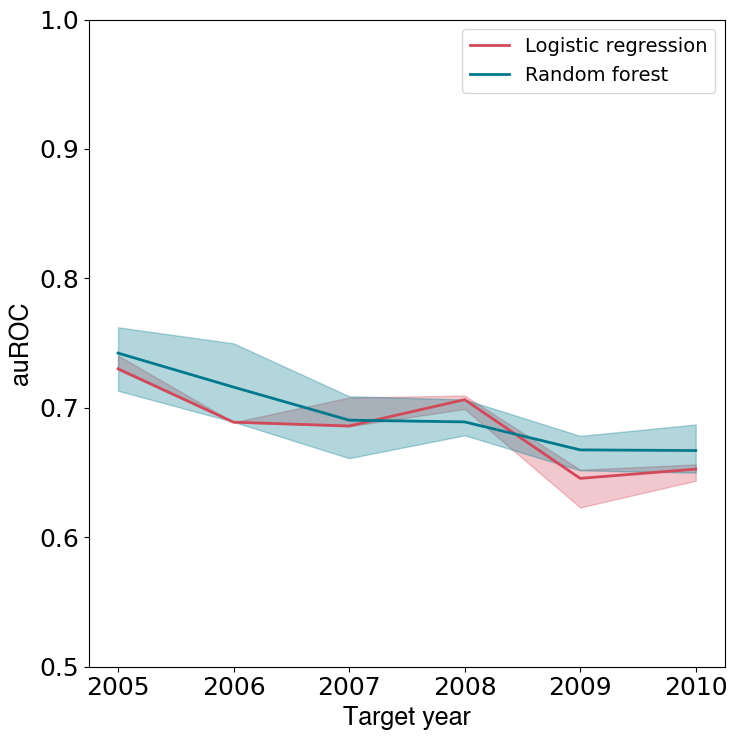

In [19]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

#axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
#axs.fill_between(years, lower_quartile_by_year[2].values(), upper_quartile_by_year[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year_preloaded[0].values(), upper_quartile_by_year_preloaded[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year_preloaded[1].values(), upper_quartile_by_year_preloaded[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()

In [ ]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

#axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")
#axs.fill_between(years, lower_quartile_by_year[2].values(), upper_quartile_by_year[2].values(), color = "#edae49", alpha = 0.3)

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")
axs.fill_between(years, lower_quartile_by_year[0].values(), upper_quartile_by_year[0].values(), color = "#d1495b", alpha = 0.3)

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")
axs.fill_between(years, lower_quartile_by_year[1].values(), upper_quartile_by_year[1].values(), color = "#00798c", alpha = 0.3)

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()


In [ ]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )

In [247]:
def effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM, prevalence_no_HI_CAL_MSM,sensitivity, specificity
):

    get_effective_threshold =   sensitivity[len(sensitivity)- 1] * prevalence_no_HI_CAL_MSM * 100 + (100 - prevalence_no_HI_CAL_MSM * 100) + prevalence_HI_CAL_MSM
    incorrectly_get_X_threshold = (100 - prevalence_HI_CAL_MSM*100 - prevalence_no_HI_CAL_MSM * 100) * (1 - specificity[len(specificity)- 1])
    return (

        get_effective_threshold,
        incorrectly_get_X_threshold,
    )

def bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, actual_sensitivity, actual_specificity):
      #1. Find apparent model performance
    lower_quartile_specificity_all = []
    upper_quartile_specificity_all = []
    lower_quartile_sensitivity_all = []
    upper_quartile_sensitivity_all = []
    for threshold in threshold_seq:
      bootstrapped_stats = []

      for j in range(iterations):
            model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
            X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
            X_train_bootstrap = pd.read_csv(X_data_name)
            model_fit = pickle.load(open(model_name, 'rb'))
            X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
            #y_sample_predict = model_fit.predict(X_test)
            y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data

            y_bootstrap_predict = np.where(y_bootstrap_predict_prob[:, 1] > threshold, 1, 0)

            tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true=y_test, y_pred=y_bootstrap_predict).ravel()

            sensitivity_test = (tp_test / (tp_test + fn_test))*100
            specificity_test = (tn_test / (tn_test + fp_test))*100

          ### (D) Calculate estimate fo variance  by getting (B) - (D) 
            difference_sensitivity = sensitivity_test - actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/
            difference_specificity = specificity_test - actual_specificity[np.where(threshold_seq ==threshold)[0][0]]  ## according to https://ocw.mit.edu/courses/18-05-introduction-to-probability-and-statistics-spring-2014/resources/mit18_05s14_reading24/


            bootstrapped_stats.append(
            {

                'Difference_specificity': difference_specificity, 
                'Difference_sensitivity': difference_sensitivity#,
            }
          )
      alpha = 0.05
      bootstrapped_stats = pd.DataFrame(bootstrapped_stats)

      upper_quartile_senstivity, lower_quartile_sensitivity = actual_sensitivity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_sensitivity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])
      upper_quartile_specificity, lower_quartile_specificity = actual_specificity[np.where(threshold_seq ==threshold)[0][0]] - np.percentile(bootstrapped_stats["Difference_specificity"], [100 * (1 - alpha / 2.0), 100 * alpha / 2.0])



      lower_quartile_specificity_all.append(lower_quartile_specificity)
      upper_quartile_specificity_all.append(upper_quartile_specificity)
      lower_quartile_sensitivity_all.append(lower_quartile_sensitivity)
      upper_quartile_sensitivity_all.append(upper_quartile_senstivity)
 ## Step 4: Get optimization-corrected performance

    return lower_quartile_specificity_all, upper_quartile_specificity_all,lower_quartile_sensitivity_all,upper_quartile_sensitivity_all

def effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R, j):
          #    model = MLPClassifier(solver = best_hyperparameters2['solver'], activation = best_hyperparameters2['activation'], max_iter = 5000 ,hidden_layer_sizes= best_hyperparameters2['hidden_layer_sizes'], alpha =  best_hyperparameters2['alpha'], random_state=337, learning_rate =best_hyperparameters2['learning_rate'])
          model_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".sav" 
          X_data_name = "/Users/rem76/Documents/ML_Models/Bootstrap_models_GISP/CIP_bootstrap_X_no_dev_" + str(model_type) + "_" + str(year) + "_" + str(j) + ".csv" 
          X_train_bootstrap = pd.read_csv(X_data_name)
          model_fit = pickle.load(open(model_name, 'rb'))
          X_test_for_bootstrap = test_data[X_train_bootstrap.columns[1:len(X_train_bootstrap.columns)]]
          #y_sample_predict = model_fit.predict(X_test)
          y_bootstrap_predict_prob = model_fit.predict_proba(X_test_for_bootstrap) #predicting it on the real data
          sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_bootstrap_predict_prob, y_test, cipro_R)

          return sensitivity_threshold_sample, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold



In [107]:
indices = [0, 100, 200, 300, 400]
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8','0.9', '1']
labels = ["A", "B", "C", "D", "E", "F" ]


# Added effective vs unnecessary 

In [226]:

CAL_HI_MSM_by_year = []
cipro_prev_outside_CAL_HI_MSM = []
for year in test_years:
    year_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'] == year]
    MSM_CIPR =  (1 - year_data.loc[year_data['MSM'] == 1, 'Susceptible']).sum()
    MSW_CIPR =  (1 - year_data.loc[year_data['MSW'] == 1, 'Susceptible']).sum()
    MSMW_CIPR =  (1 - year_data.loc[year_data['MSMW'] == 1, 'Susceptible']).sum()
    Other_CIPR =  (1 - year_data.loc[year_data['Oth/Unk/Missing'] == 1, 'Susceptible']).sum()

    Not_MSM = MSW_CIPR + MSMW_CIPR + Other_CIPR
    HI_CAL =   (1 - (year_data[(year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'])).sum()
    Not_CAL_HI =  (1 - (year_data[(~year_data['CLINIC'].isin(['HON', 'SDG', 'SFO', 'ORA', 'LAX', 'LBC'])) & (year_data['MSM'] == 0)]['Susceptible'])).sum()
    cipro_prev_outside_CAL_HI_MSM.append((Not_MSM + Not_CAL_HI)/(len(year_data)))
    CAL_HI_MSM_by_year.append((MSM_CIPR + HI_CAL)/(len(year_data)))


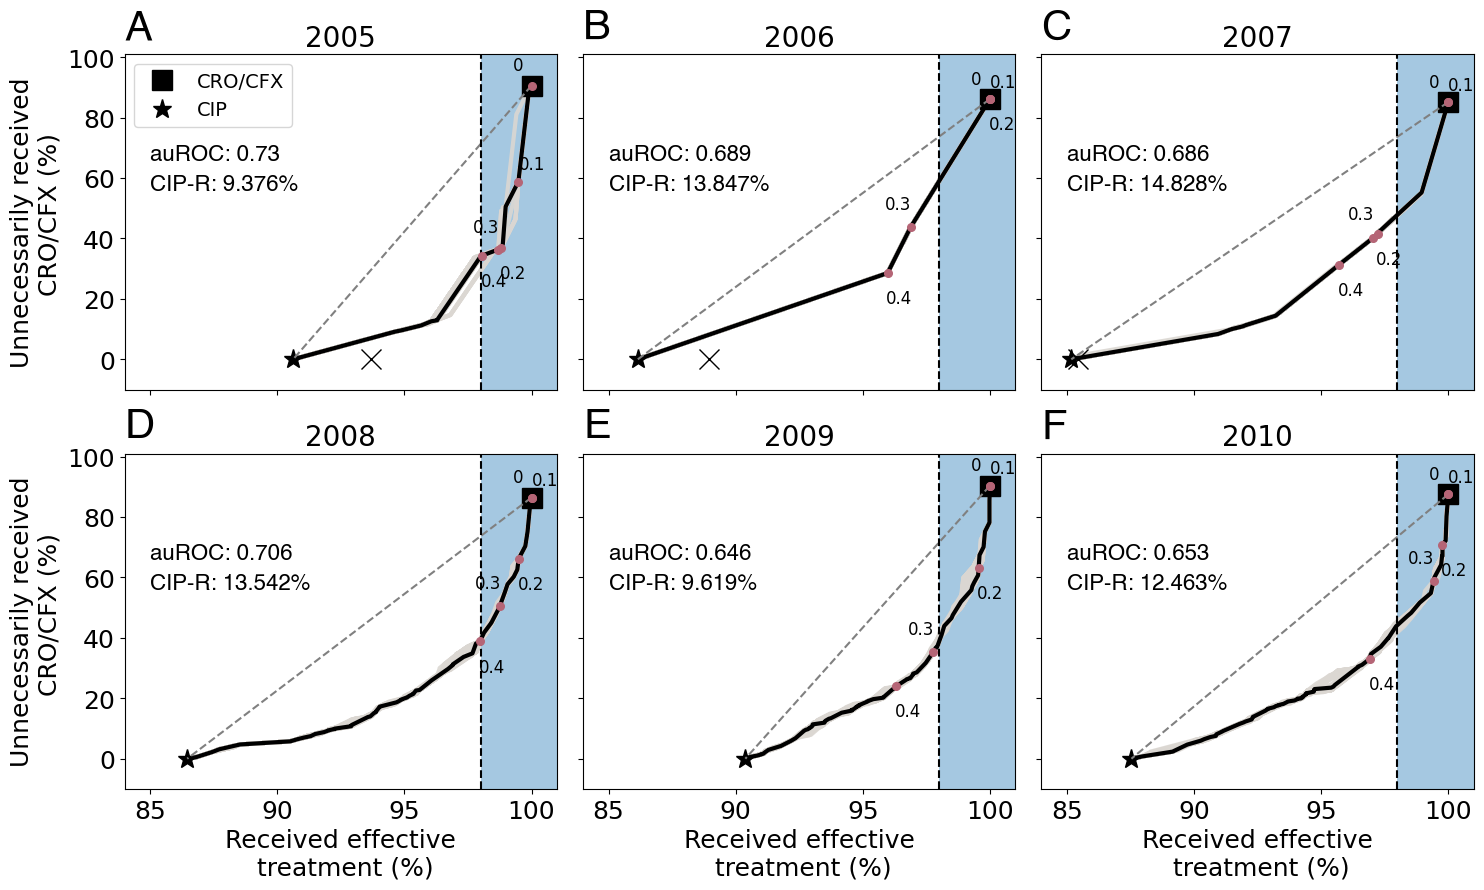

In [250]:
###### Effect of threshold on year-by-year for logistic regression with bootstrapping
iterations = 100
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4'] #, '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0, 100, 200, 300, 400] #, 500, 600, 700, 800, 900, 1000]
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)


axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])
axs = axs.ravel()
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_lr = []
i = 0
years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years:
    model_type = 0
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_lr.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    #plot
    for j in range(iterations):
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)

        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)

    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    
    # account for CAL_HI_MSM rule sensitivity, specificity
    if year in [2005, 2006, 2007]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold)[0]
        
        axs[i].plot(effective_with_CDC_rules,0, marker='x', ls='none', ms=14, color = "black")

    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 6, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 10, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

plt.tight_layout()
axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('Graphs/Percent_effective_unnecessary_all_logistic_regression_2005_2010_weights_extra_features.png', dpi = 300)


Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


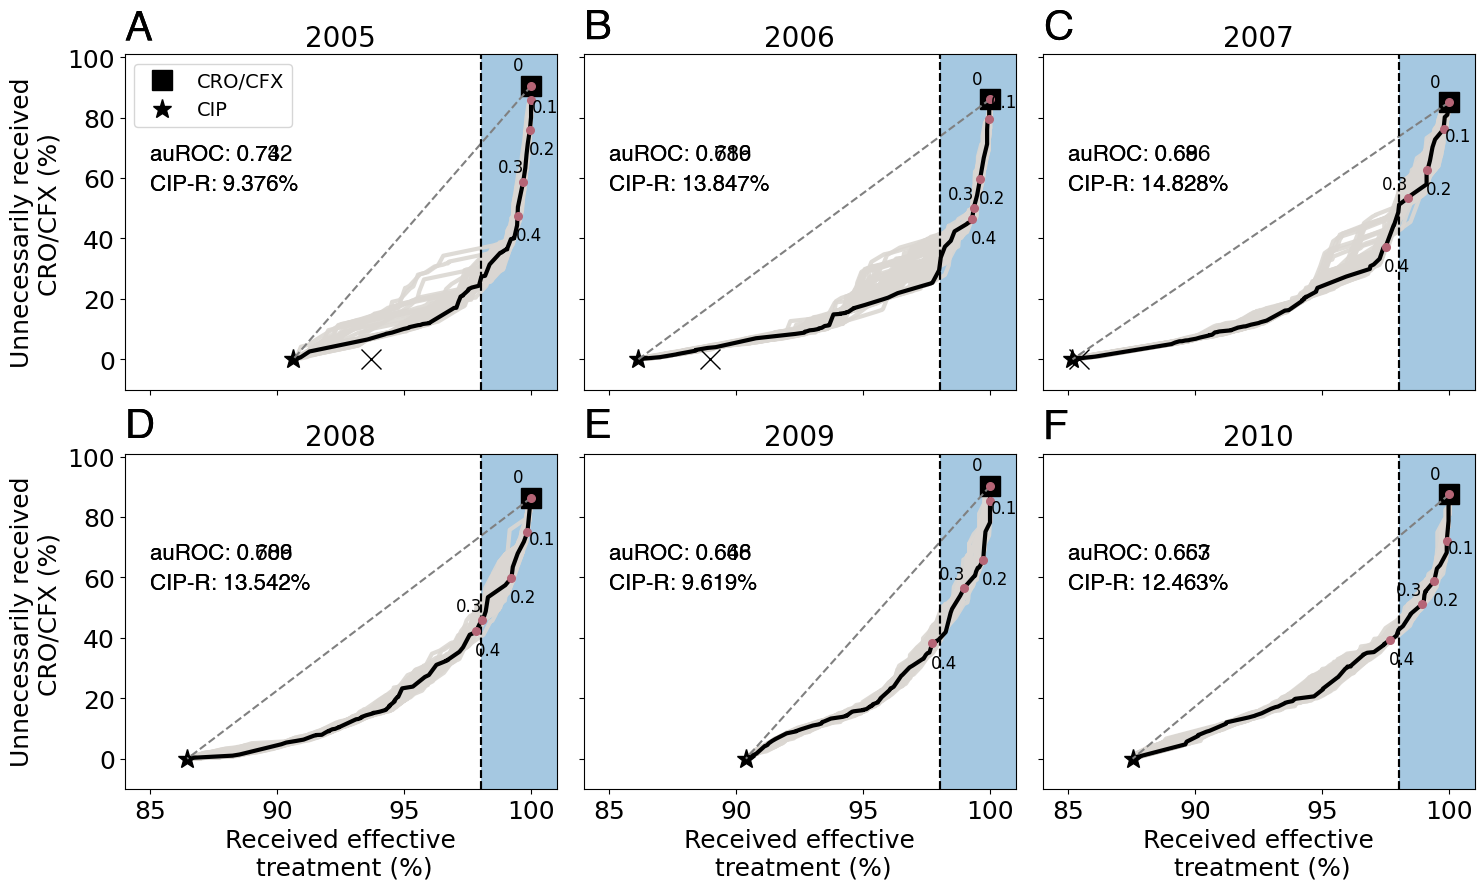

In [251]:
###### Effect of threshold on year-by-year for random forest model with bootstrap
from matplotlib.patches import Polygon
iterations = 100
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
polygon_important0 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important1 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important2 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important3 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important4 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)
polygon_important5 = Polygon([(98,110), (110,110), (110,-10), (98,-10)], alpha = 0.4)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n  CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([85, 90, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-10,101])
axs[0,0].set_xlim([84, 101])


axs = axs.ravel()

cip_R_all_years = []
threshold_seq = np.linspace(0,1,1001)
unneccessary_treatment_98_efficacy_rf = []
i = 0
for year in years:
    model_type =1 
    years_train = np.array(range(year - 5, year))
    
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    #plot
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    unneccessary_treatment_98_efficacy_rf.append(incorrectly_get_X_threshold[get_effective_threshold.index(min([x for x in get_effective_threshold if x >= 98]))] )

    for j in range(iterations):
        #sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap( model_rf, train_data, feature_names, test_data, y_test, cipro_R_prev)
        sensitivity_threshold_sample, specificity_threshold_sample, get_effective_threshold_sample, incorrectly_get_X_threshold_sample = effective_unnecessary_bootstrap_preloaded(test_data, y_test, cipro_R_prev, j)

        axs[i].plot(get_effective_threshold_sample, incorrectly_get_X_threshold_sample, color = "#DBD7D2", linewidth = 3, alpha=0.9)
    axs[i].plot(get_effective_threshold, incorrectly_get_X_threshold, color = "black", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    if year in [2005, 2006, 2007]:
        effective_with_CDC_rules  = effective_unnecessary_threshold_with_HI_MSM_CAL(prevalence_HI_CAL_MSM = CAL_HI_MSM_by_year[i], prevalence_no_HI_CAL_MSM = cipro_prev_outside_CAL_HI_MSM[i], sensitivity = sensitivity_threshold, specificity = specificity_threshold)[0]
        
        axs[i].plot(effective_with_CDC_rules,0, marker='x', ls='none', ms=14, color = "black")

    axs[i].plot([100, (1-cipro_R_prev)*100], [(1-cipro_R_prev)*100, 0], color = "#808080", linestyle="--")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year_lr[year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].set_title(year,fontsize=20)  
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 1 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}%', fontsize = 16, **hfont)
    axs[i].axvline(x = 98, color = 'black', linestyle="--")
    x = 0
    for index in indices:
        axs[i].plot(get_effective_threshold[index], incorrectly_get_X_threshold[index], marker='.', ls='none', ms=11, color = "#b56576")
        if index in (300, 500, 700, 900):
            if year == 2009 & index == 700:
                axs[i].text(get_effective_threshold[index] , incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] - 1, incorrectly_get_X_threshold[index] + 3, text_for_graph[x], size = 12)
        elif index in (200, 400, 800, 1000):
            axs[i].text(get_effective_threshold[index] - 0.05, incorrectly_get_X_threshold[index] - 8, text_for_graph[x], size = 12)
        elif index == 600:
            axs[i].text(get_effective_threshold[index] - 0.25, incorrectly_get_X_threshold[index] - 7, text_for_graph[x], size = 12)
        elif index == 100:
            if year == 2006:
                axs[i].text(get_effective_threshold[index] + 0.075, incorrectly_get_X_threshold[index]  +4, text_for_graph[x], size = 12)
            else:
                axs[i].text(get_effective_threshold[index] + 0.05 , incorrectly_get_X_threshold[index] -4, text_for_graph[x], size = 12)
        elif index == 0:
            axs[i].text(get_effective_threshold[index] - 0.75, incorrectly_get_X_threshold[index] + 5, text_for_graph[x], size = 12)
        
        x = x+1
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1

plt.tight_layout()

axs[0].legend(prop={'size':14})
axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.savefig('Graphs/Percent_effective_unnecessary_all_random_forest_2005_2010_bootstrap_weights_extra_features.png', dpi = 300)

# SI Graphs

Senistivity and specificity

Functions for SI

Oversample
Oversample
Oversample
Oversample
Oversample
Oversample


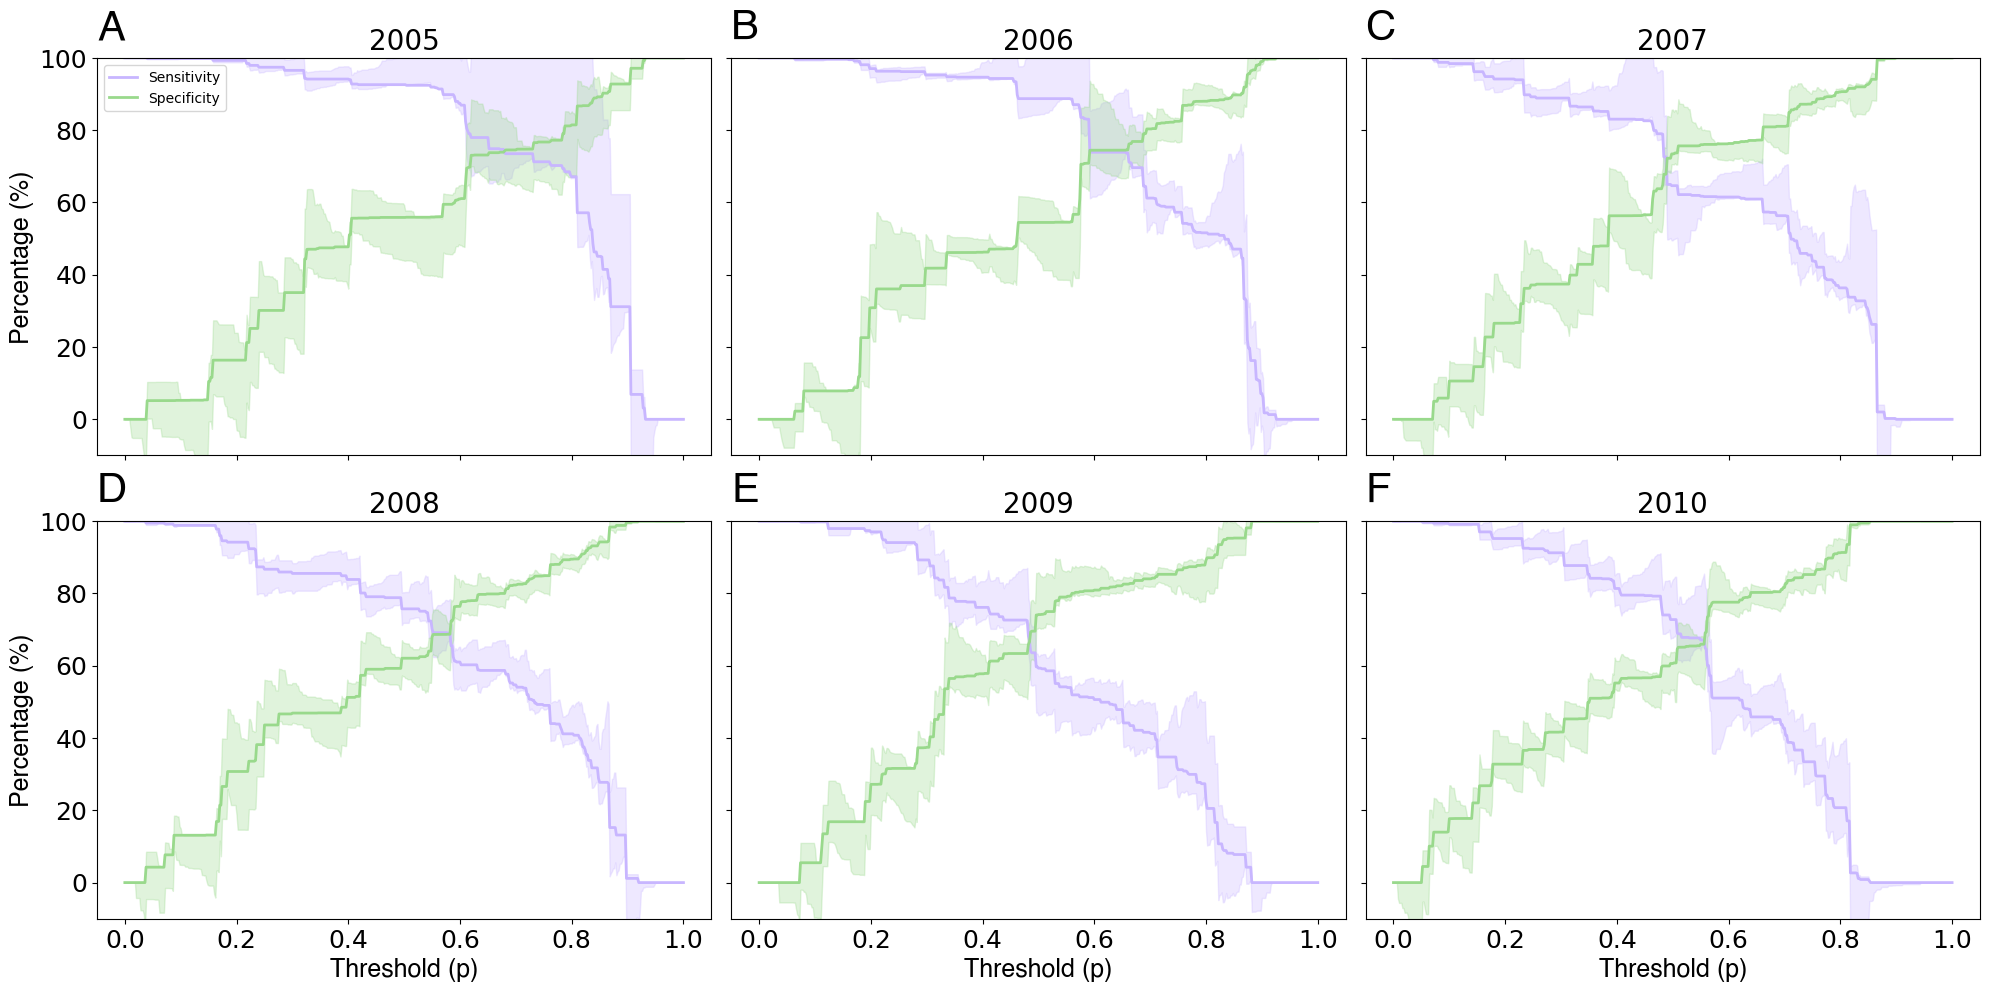

In [135]:
### RF Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)
years = [2005, 2006, 2007, 2008, 2009, 2010]
i = 0
for year in years:
    model_type = 1
    years_train = np.array(range(year - 5, year))
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)


    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_random_forest_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

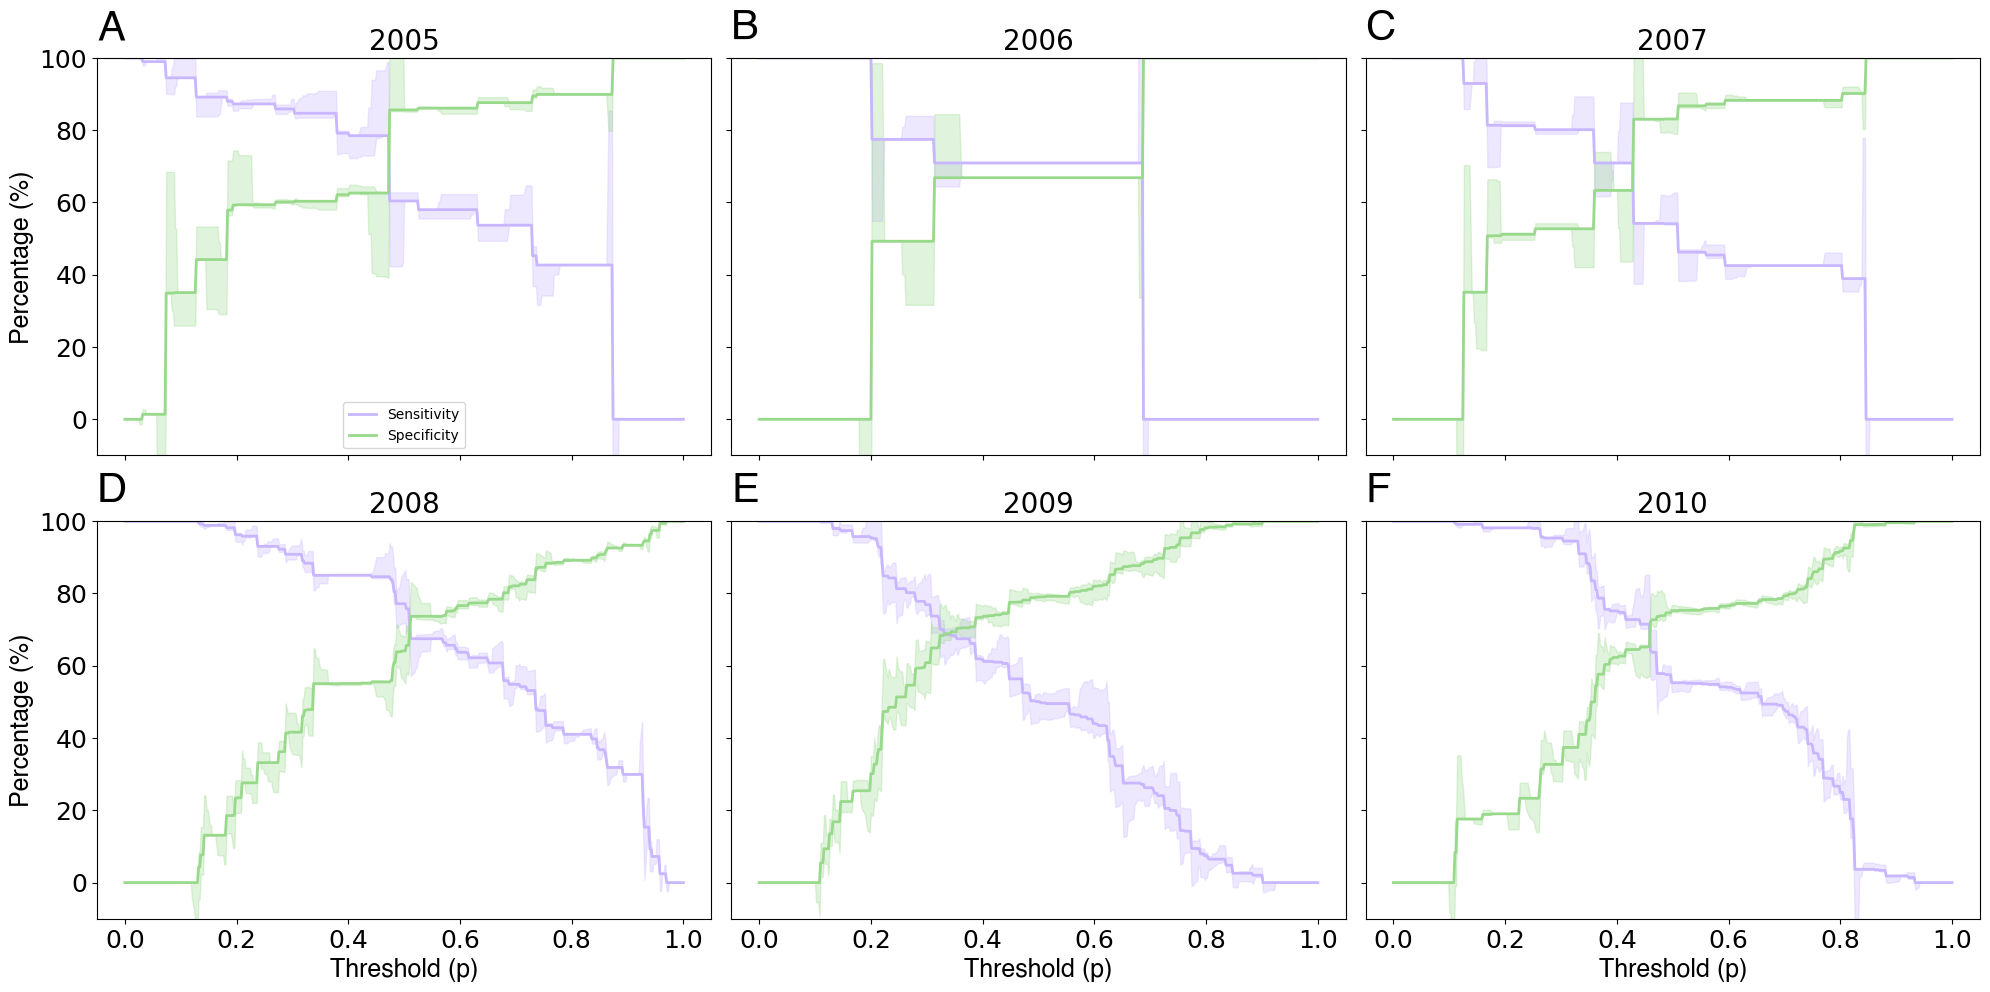

In [138]:
### LR Bootstrap sensitivity and specificity 
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
labels = ["A", "B", "C", "D", "E", "F" ]
years = [2005, 2006, 2007, 2008, 2009, 2010]
axs[0,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_ylabel('Percentage (%)', fontsize=18,**hfont)
axs[1,0].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,1].set_xlabel('Threshold (p)', fontsize=18,**hfont)
axs[1,2].set_xlabel('Threshold (p)', fontsize=18,**hfont)

axs[0,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,1].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[1,2].set_xticks(np.linspace(0,1,6), fontsize=18,**hfont)
axs[0,0].set_ylim(-10, 100)
axs[0,1].set_ylim(-10, 100)
axs[0,2].set_ylim(-10, 100)
axs[1,0].set_ylim(-10, 100)
axs[1,1].set_ylim(-10, 100)
axs[1,2].set_ylim(-10, 100)
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs = axs.ravel()

threshold_seq = np.linspace(0,1,501)

i = 0
for year in years:
    model_type = 0
    years_train = np.array(range(year - 5, year))
    important_features = best_features_by_year[model_type][year]
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = 0)

    model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = best_hyperparameters_by_year[model_type][year]['solver'], C = best_hyperparameters_by_year[model_type][year]['C'], penalty = best_hyperparameters_by_year[model_type][year]['penalty'])
    
    ## fit model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
    
    ## get sesnitivity and specificity
    sensitivity_threshold, specificity_threshold, get_effective_threshold, incorrectly_get_X_threshold = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    lower_quartile_specificity, upper_quartile_specificity,lower_quartile_sensitivity,upper_quartile_sensitivity = bootstrap_sensitivity_specificity_preloaded(iterations,  y_test, sensitivity_threshold, specificity_threshold)

    #plot
    axs[i].plot(threshold_seq, sensitivity_threshold, color = "#c8b6ff", label = r"Sensitivity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_sensitivity, upper_quartile_sensitivity, color = "#c8b6ff", alpha = 0.3)

    axs[i].plot(threshold_seq, specificity_threshold, color = "#99d98c", label = r"Specificity", linewidth = 2)
    axs[i].fill_between(threshold_seq, lower_quartile_specificity, upper_quartile_specificity, color = "#99d98c", alpha = 0.3)
    axs[i].set_title(year,fontsize=20)

    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1
axs[0].legend()
plt.tight_layout()

plt.savefig("Graphs/Sensitivity_specificity_all_workflow_paper_logistic_regression_2005_2010_bootstrap_weights_extra_features.png", dpi = 300)

# LOOCV 

In [97]:
def effective_unnecessary_threshold(
    threshold_seq, y_predict_proba, y_test, cipro_R_prevalence
):

    get_effective_threshold = []
    incorrectly_get_X_threshold = []  # no bootstrapping, no 95% CI
    sensitivity_threshold = []
    specificity_threshold = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test, fp_test, fn_test, tp_test = confusion_matrix(
            y_true=y_test, y_pred=y_predict_test
        ).ravel()

        sensitivity_test = tp_test / (tp_test + fn_test)
        specificity_test = tn_test / (tn_test + fp_test)

        sensitivity_threshold.append(sensitivity_test * 100)
        specificity_threshold.append(specificity_test * 100)
        get_effective_threshold.append(
            sensitivity_test * cipro_R_prevalence * 100
            + (100 - cipro_R_prevalence * 100)
        )  # q_p
        incorrectly_get_X_threshold.append(
            (100 - cipro_R_prevalence * 100) * (1 - specificity_test)
        )  # c_p"
    return (
        sensitivity_threshold,
        specificity_threshold,
        get_effective_threshold,
        incorrectly_get_X_threshold,
    )


In [116]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

In [117]:
### Leave one out validation for random forest
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

##"full model"
fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)

axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=18,**hfont)

axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0

for year in test_years: 
    years_train = np.array(range(year - 5, year))
    model_type = 1
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    
    ## Load saved model
    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ## fit model w/hyperparameters 
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]
        oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

          #train data - does not have clinic
        X_train = train_data[best_features_by_year[model_type][year]]
        y_train = 1 - train_data['Susceptible']
        X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year[model_type][year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          if cipro_R_prev < cipro_R:
              col = '#DBABBE'
              alpha_graph = 0.4
          else:
              col = '#ffc07c'
              alpha_graph = 0.4

          try:
          # test 
              X_test, y_test = oversample.fit_resample(X_test,y_test)

              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:
            try:
              oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42)
          #train data - does not have clinic
              X_train, y_train = oversample.fit_resample(X_train,y_train)

          #test data - has clinic 

              X_test, y_test = oversample.fit_resample(X_test,y_test)
            # test 
              model_fit_train = model_rf.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)

              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3) 
            except ValueError:
              print('x')
              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)
    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #

axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)
plt.tight_layout()
#plt.savefig("Graphs/LOOCV_effective_unnecessary_all_workflow_paper_random_forest_2005_2010_coloured.png", dpi = 300)

Oversample
Oversample
Oversample
Oversample
Oversample


In [ ]:
### Leave one out validation for logistic regression 
from matplotlib.patches import Polygon
polygon_important0 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important1 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important2 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important3 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important4 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)
polygon_important5 = Polygon([(95,100), (100,100), (100,0), (95,0)], alpha = 0.4)

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')

axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_ylabel("Unnecessarily received\n CRO/CFX (%)", fontsize = 18)
axs[1,0].set_ylabel("Unnecessarily received\n CRO/CFX therapy (%)", fontsize = 18)
axs[1,0].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,1].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[1,2].set_xlabel("Received effective\n treatment (%)", fontsize = 18)
axs[0,0].set_yticks(np.linspace(0,100,6), labelsize=18,**hfont)
axs[1,0].set_yticks(np.linspace(0,100,6), fontsize=18,**hfont)
axs[1,0].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,1].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)
axs[1,2].set_xticks([45, 55, 65, 75, 85, 95, 100], fontsize=17,**hfont)


axs[0,0].set_ylim([0-5,101])
axs[0,0].set_xlim([44, 101])
axs[0,1].set_ylim([0-5,101])
axs[0,1].set_xlim([44, 101])
axs[0,2].set_ylim([0-5,101])
axs[0,2].set_xlim([44, 101])
axs[1,0].set_ylim([0-5,101])
axs[1,0].set_xlim([44, 101])
axs[1,1].set_ylim([0-5,101])
axs[1,1].set_xlim([44, 101])
axs[1,2].set_ylim([0-5,101])
axs[1,2].set_xlim([44, 101])
fig.subplots_adjust(hspace = .15, wspace=.1)
axs = axs.ravel()
i = 0
threshold_seq = np.linspace(0,1,1001)

years = [2005, 2006, 2007, 2008, 2009, 2010]
for year in years: 
    years_train = np.array(range(year - 5, year))

    model_type = 0
    # first do for all clinics 
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 
    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, sample_weights  =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year],years_train = years_train, model_type = model_type)
    
    ## Load saved model
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit_train = pickle.load(open(model_name, 'rb'))
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    ## fit model w/hyperparameters 
    model_fit_train = model_rf.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)
 
    senstivitity_threshold_all, specificity_threshold_all, get_effective_threshold_all, incorrectly_get_X_threshold_all = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R_prev)
    #get_effective_threshold_rf = get_effective_threshold
    #incorrectly_get_X_threshold_rf = incorrectly_get_X_threshold

    clinics = CIP_data_testing_years["CLINIC"].unique()
    for clinic in clinics: 
        train_data = CIP_data_training_years.loc[CIP_data_training_years['CLINIC'] != clinic]

          #train data - does not have clinic
        X_train = train_data[best_features_by_year_lr[year]]
        y_train = 1 - train_data['Susceptible']

          #test data - has clinic 
        test_data = CIP_data_testing_years.loc[CIP_data_testing_years['CLINIC'] == clinic]
        X_test = test_data[best_features_by_year_lr[year]]
        y_test = 1 - test_data['Susceptible']
        cipro_R = y_test.sum()/len(y_test)

        if cipro_R > 0: 
          try:
          # test 
            
              model_fit_train = model_lr.fit(X_train, y_train)
              y_predict_test = model_fit_train.predict(X_test)
              y_predict_proba = model_fit_train.predict_proba(X_test)
              senstivitity_threshold_clinic, specificity_threshold_clinic, get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic = effective_unnecessary_threshold(threshold_seq, y_predict_proba, y_test, cipro_R)
              if cipro_R_prev < cipro_R:
                col = '#DBABBE'
                alpha_graph = 0.8
              else:
                 col = '#ffc07c'
                 alpha_graph = 0.8
              axs[i].plot(get_effective_threshold_clinic, incorrectly_get_X_threshold_clinic,color = col, linewidth = 3, alpha=alpha_graph)
              #axs[i].plot(get_effective_threshold_clinic[0:index_for_plot], incorrectly_get_X_threshold_clinic[0:index_for_plot],color = "#457b9d", linewidth = 3, alpha=0.7)

              axs[i].plot(100, (1 - cipro_R)*100, marker='s', ls='none', ms=12, color = col, alpha=0.3)
              axs[i].plot((1-cipro_R)*100, 0, marker='*', ls='none', ms=12, color = col, alpha=0.3)
   

          
          except ValueError:

              pass

    index_for_plot = np.max(np.where(np.array(get_effective_threshold_all)>95))

    axs[i].plot(get_effective_threshold_all, incorrectly_get_X_threshold_all,color = "black", linewidth = 3)
    #axs[i].plot(get_effective_threshold_all[0:index_for_plot], incorrectly_get_X_threshold_all[0:index_for_plot],color = "#457b9d", linewidth = 3)

    axs[i].plot(100, (1 - cipro_R_prev)*100, marker='s', ls='none', ms=14, color = "black", label = "CRO/CFX")
    axs[i].plot((1-cipro_R_prev)*100, 0, marker='*', ls='none', ms=14, color = "black", label = "CIP")
    axs[i].text(axs[i].get_xlim()[0] , axs[i].get_ylim()[1] + 5, labels[i], fontsize = 30, **hfont)
    axs[i].axvline(x = 95, color = 'black', linestyle="--")

    axs[i].set_ylim([0-5,101])
    axs[i].set_xlim([44, 101])
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 35, f'auROC: {round(ROC_by_year[model_type][year], 3)}', fontsize = 16, **hfont)
    axs[i].text(axs[i].get_xlim()[0] + 5 , axs[i].get_ylim()[1] - 45, f'CIP-R: {round(cipro_R_prev*100, 3)}', fontsize = 16, **hfont)
    axs[i].set_title(year,fontsize=20)   
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)

    i += 1   #
axs[0].legend(prop={'size':14})

axs[0].add_patch(polygon_important0)
axs[1].add_patch(polygon_important1)
axs[2].add_patch(polygon_important2)
axs[3].add_patch(polygon_important3)
axs[4].add_patch(polygon_important4)
axs[5].add_patch(polygon_important5)

plt.tight_layout()